# Variational Quantum Time Evolution

This notebook presentation is part of my lecture material for the Advanced Quantum Mechanics course at the University of Trieste. It contains a general introduction to variational quantum time evolution.

**Michele Grossi**, Senior Researcher @ CERN \

This notebook demonstrates how to use the Variational Quantum Time Evolution (VarQTE) algorithm for computing the time evolving state under a given Hamiltonian. Specifically, it introduces variational quantum imaginary and real time evolution based on McLachlan's variational principle, and shows how this can be leveraged using the `time_evolvers.variational` sub-module.

## Introduction
The time evolution of a quantum state $|\Psi\rangle$ is governed by the Schrödinger equation (here with $\hbar \equiv 1$)

$$
    \frac{d}{dt} |\Psi(t)\rangle = -i H |\Psi(t)\rangle,
$$


or without the factor $i$ for imaginary time dynamics.

In VarQTE, the time evolution of the _state_ $|\Psi(t)\rangle$ is replaced by the evolution of _parameters_ $\theta(t)$ in a variational ansatz $|\psi[\theta(t)]$ ([Yuan et al. Quantum 3, 191](https://quantum-journal.org/papers/q-2019-10-07-191/)). Using the McLachlan variational principle, the algorithm updates the parameters by minimizing the distance between the right-hand side and left-hand side of the equation above, that is

$$
\dot\theta(t) = \mathrm{argmin} \Bigg\| \left(\frac{d}{dt} + i H\right)|\psi[\theta(t)]\rangle \Bigg\|,
$$

with the norm $\| |\psi\rangle \| = \sqrt{\langle\psi | \psi\rangle}$. This is equivalent to solving the following linear system of equations

$$
\sum_{ij}F_{ij}\dot{\theta}_{i}=V_{j}
$$

where

$$F_{ij}=\text{Re}\left[\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}\frac{\partial\left|\psi\left[\theta\right]\right\rangle }{\partial\theta_{j}}+\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}\left|\psi\left[\theta\right]\right\rangle \left\langle \psi\left[\theta\right]\right|\frac{\partial\left|\psi\left[\theta\right]\right\rangle }{\partial\theta_{j}}\right]$$,

and

$$V_{i}=\begin{cases}
\text{Im}\left[\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}H\left|\psi\left[\theta\right]\right\rangle +\left\langle \psi\left[\theta\right]\right|\frac{\partial\left|\psi\left[\theta\right]\right\rangle }{\partial\theta_{i}}\left\langle H\right\rangle _{\theta}\right] & \text{Real time}\\
-\text{Re}\left[\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}H\left|\psi\left[\theta\right]\right\rangle \right] & \text{Imaginary time}
\end{cases}$$.


## Running VarQTE

In this tutorial, we will use two classes that extend `VarQTE`, `VarQITE` ([Variational Quantum Imaginary Time Evolution](https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.VarQITE.html#qiskit_algorithms.VarQITE)) and `VarQRTE` ([Variational Quantum Real Time Evolution](https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.VarQRTE.html)) for time evolution.
We can use a simple Ising model on a spin chain to illustrate this. Let us consider the following Hamiltonian:

$$H = -J\sum_{i=0}^{L-2}Z_{i}Z_{i+1} - h\sum_{i=0}^{L-1}X_i$$

where $J$ stands for the interaction energy, and
$h$ represents an external field which is orthogonal to the transverse direction. $Z_i$ and $X_i$ are the Pauli operators on the spins. Taking $L=2$, $J=0.2$,  and $h =1$, the Hamiltonian and the magnetization $\sum_i Z_i$ can be constructed using `SparsePauliOp` as follows:

In [1]:
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp(["ZZ", "IX", "XI"], coeffs=[-0.2, -1, -1])

magnetization = SparsePauliOp(["IZ", "ZI"], coeffs=[1, 1])

## Imaginary Time Evolution

Imaginary time evolution can be used, for example, to find the ground state or calculate the finite temperature expectation value of the system. Here, we will use the `VarQITE` class from `time_evolvers.variational` to compute a ground state energy. Firstly, we need to choose an ansatz. We can use `EfficientSU2` to easily construct an ansatz, setting the number of repetitions using `reps`.

## Real Time Evolution
Real time evolution is a suitable task such as simulating quantum dynamics. For example, one can use `VarQRTE` to get time evolving expectation values of the magnetization.


### VarQRTE
Again, the first step is to select an ansatz.

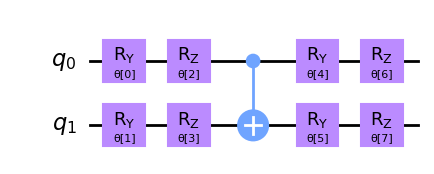

In [2]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(hamiltonian.num_qubits, reps=1)
ansatz.decompose().draw("mpl")

We set all initial parameters as $\frac{\pi}{2}$.

In [3]:
import numpy as np

init_param_values = {}

for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]] = (
        np.pi / 2
    )  # initialize the parameters which also decide the initial state

We also define an initial state:

In [4]:
from qiskit.quantum_info import Statevector

init_state = Statevector(ansatz.assign_parameters(init_param_values))
print(init_state)

Statevector([-5.00000000e-01+5.07326818e-18j,
             -5.00000000e-01-6.66967228e-17j,
              3.89411472e-17-5.00000000e-01j,
              1.55347882e-16+5.00000000e-01j],
            dims=(2, 2))


In order to use the real time McLachlan principle, we instantiate the `RealMcLachlanPrinciple` class.

In [5]:
from qiskit_algorithms.time_evolvers.variational import RealMcLachlanPrinciple

var_principle = RealMcLachlanPrinciple()

We also set the target time as $t=10$, and set the auxiliary operator to be the magnetization operator. The following steps are similar to `VarQITE`.


In [6]:
aux_ops = [magnetization]

In [7]:
from qiskit_algorithms import VarQRTE
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import VarQITE
from qiskit.primitives import Estimator

time = 10.0
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qrte = VarQRTE(ansatz, init_param_values, var_principle, Estimator())
evolution_result_re = var_qrte.evolve(evolution_problem)

We can also obtain the exact solution with `SciPyRealEvolver`. We first create the corresponding initial state for the exact classical method.

In [8]:
init_circ = ansatz.assign_parameters(init_param_values)

`SciPyRealEvolver` can help us get the classical exact result.

In [9]:
from qiskit_algorithms import SciPyRealEvolver

evolution_problem = TimeEvolutionProblem(
    hamiltonian, time, initial_state=init_circ, aux_operators=aux_ops
)
rtev = SciPyRealEvolver(1001)
sol = rtev.evolve(evolution_problem)

We can compare the results, where $m_z$ represents the magnetization.

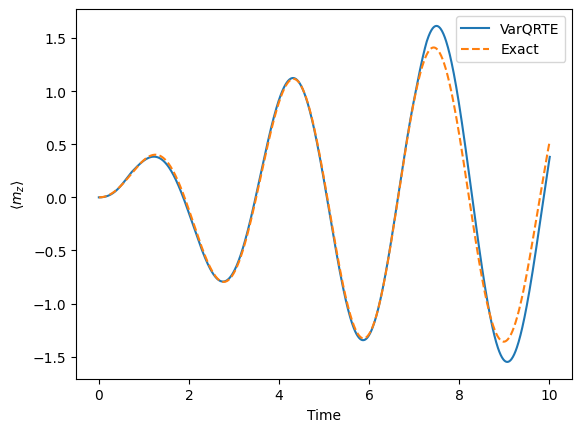

In [10]:
import pylab

mz_exp_val_re = np.array([ele[0][0] for ele in evolution_result_re.observables])
exact_mz_exp_val_re = sol.observables[0][0].real
times = evolution_result_re.times
pylab.plot(times, mz_exp_val_re, label="VarQRTE")
pylab.plot(times, exact_mz_exp_val_re, label="Exact", linestyle="--")
pylab.xlabel("Time")
pylab.ylabel(r"$\langle m_z \rangle$")
pylab.legend(loc="upper right");

### Efficient classical Way to run VarQRTE

You can use classically efficient gradient calculations to speed up the time evolution simulation by setting `qpt` as `ReverseQGT()` and `gradient` as `ReverseEstimatorGradient()`.


In [11]:
from qiskit_algorithms.gradients import DerivativeType
from qiskit_algorithms.gradients import ReverseEstimatorGradient, ReverseQGT

var_principle = RealMcLachlanPrinciple(
    qgt=ReverseQGT(), gradient=ReverseEstimatorGradient(derivative_type=DerivativeType.IMAG)
)
time = 10.0
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qrte = VarQRTE(ansatz, init_param_values, var_principle, Estimator())
evolution_result_re_eff = var_qrte.evolve(evolution_problem)

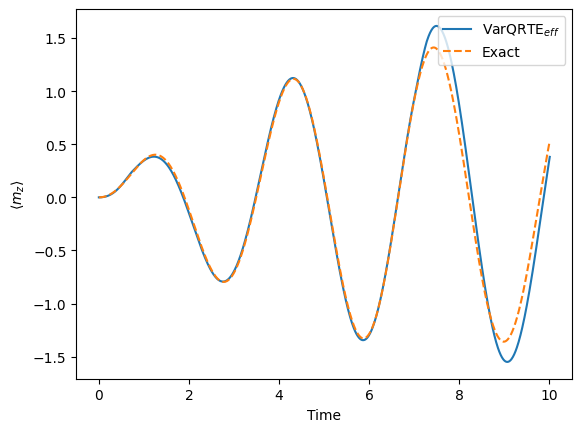

In [12]:
mz_exp_val_re_eff = np.array([ele[0][0] for ele in evolution_result_re_eff.observables])
pylab.plot(times, mz_exp_val_re_eff, label=r"VarQRTE$_{eff}$")
pylab.plot(times, exact_mz_exp_val_re, label="Exact", linestyle="--")
pylab.xlabel("Time")
pylab.ylabel(r"$\langle m_z \rangle$")
pylab.legend(loc="upper right");

Again, the accuracies of `VarQRTE` with both gradient methods are very similar, while the `ReverseEstimatorGradient()` shows a speedup of about $21\%$ in this execution.

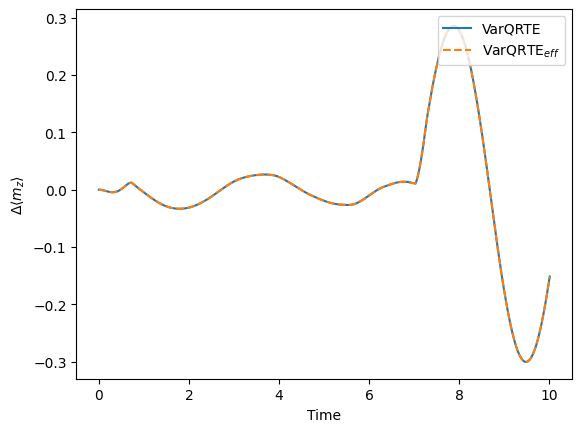

In [13]:
pylab.plot(times, (mz_exp_val_re - exact_mz_exp_val_re), label="VarQRTE")
pylab.plot(
    times, (mz_exp_val_re_eff - exact_mz_exp_val_re), label=r"VarQRTE$_{eff}$", linestyle="--"
)
pylab.xlabel("Time")
pylab.ylabel(r"$\Delta \langle m_z \rangle$")
pylab.legend(loc="upper right");

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright